In [ ]:
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import  models

In [ ]:
data_path="/kaggle/input/vehicle-classification-dataset/vehicle_classification_data"

os.listdir(data_path)

['large_truck', 'bus', 'truck', 'microbus', 'car', 'semi_truck', 'mini_bus']

In [ ]:
!mkdir train
!mkdir test
!mkdir val

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
%cd /kaggle/working/train
!mkdir mini_bus  microbus  car  truck  large_truck  semi_truck  bus

/kaggle/working/train
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
%cd /kaggle/working/test
!mkdir mini_bus  microbus  car  truck  large_truck  semi_truck  bus

/kaggle/working/test
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
%cd /kaggle/working/val
!mkdir mini_bus  microbus  car  truck  large_truck  semi_truck  bus

/kaggle/working/val
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
%cd /kaggle/working

/kaggle/working


In [ ]:
for folder in os.listdir(data_path):
    class_path=data_path+'/'+folder
    _all=os.listdir(class_path)
    cuttoff=int(len(_all)*0.80)
    train=_all[:cuttoff]
    tmp=_all[cuttoff:]
    cuttoff=int(len(tmp)*0.50)
    val=tmp[:cuttoff]
    test=tmp[cuttoff:]
    for image in train:
        shutil.copy(str(class_path+'/'+image),str("/kaggle/working/train/"+folder+'/'+image))
    for image in test:
        shutil.copy(str(class_path+'/'+image),str("/kaggle/working/test/"+folder+'/'+image))
    for image in val:
        shutil.copy(str(class_path+'/'+image),str("/kaggle/working/val/"+folder+'/'+image))

In [ ]:
%cd /kaggle/working/

/kaggle/working


In [ ]:
for cl in os.listdir("/kaggle/working/train"):
    if cl=='.ipynb_checkpoints':
        continue
    train_images=os.listdir(str("/kaggle/working/train/"+cl))
    test_images=os.listdir("/kaggle/working/test/"+cl)
    val_images=os.listdir("/kaggle/working/val/"+cl)
    print(f"training images of {cl} equal {len(train_images)} ,validation {len(val_images)} and testing {len(test_images)} image.")

training images of car equal 484 ,validation 61 and testing 61 image.
training images of truck equal 401 ,validation 50 and testing 51 image.
training images of bus equal 202 ,validation 25 and testing 26 image.
training images of microbus equal 470 ,validation 59 and testing 59 image.
training images of large_truck equal 214 ,validation 27 and testing 27 image.
training images of semi_truck equal 473 ,validation 59 and testing 60 image.
training images of mini_bus equal 45 ,validation 6 and testing 6 image.


In [ ]:
# Define data generators for my training and validation data
train_dir="/kaggle/working/train"
val_dir="/kaggle/working/val"
batch_size=32
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

y = train_generator.classes
class_weights = compute_class_weight(class_weight = "balanced",classes =np.unique(y), y = y)
class_weights_dict = dict(zip(range(len(np.unique(y))), class_weights))

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 2289 images belonging to 7 classes.
Found 287 images belonging to 7 classes.


In [ ]:
class_weights_dict

{0: 1.618811881188119,
 1: 0.6756198347107438,
 2: 1.52803738317757,
 3: 0.6957446808510638,
 4: 7.266666666666667,
 5: 0.6913319238900634,
 6: 0.8154613466334164}

In [ ]:
train_generator.class_indices.keys()

dict_keys(['bus', 'car', 'large_truck', 'microbus', 'mini_bus', 'semi_truck', 'truck'])

In [ ]:
# Load pre-trained ResNet50 model (with imagenet weights)
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#ADD regualization and dropout
for layer in resnet.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        layer.kernel_regularizer = regularizers.l2(0.01)
        layer.dropout = Dropout(0.5)

# Freeze all layers in the ResNet50 model
for layer in resnet.layers:
    layer.trainable = False

# Define new output layers
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

# Create a new model that includes the pre-trained ResNet50 layers and your own output layers
model = models.Model(inputs=resnet.input, outputs=output)

model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model with early stopping
history = model.fit(train_generator, epochs=100,class_weight=class_weights_dict, validation_data=val_generator)

Epoch 1/100
72/72 [==============================] - 22s 196ms/step - loss: 14.7108 - accuracy: 0.5068 - val_loss: 8.5997 - val_accuracy: 0.7875
Epoch 2/100
72/72 [==============================] - 13s 174ms/step - loss: 7.1158 - accuracy: 0.7208 - val_loss: 5.2341 - val_accuracy: 0.8118
Epoch 3/100
72/72 [==============================] - 12s 172ms/step - loss: 4.8372 - accuracy: 0.7580 - val_loss: 3.7803 - val_accuracy: 0.8432
Epoch 4/100
72/72 [==============================] - 13s 174ms/step - loss: 3.4757 - accuracy: 0.8187 - val_loss: 2.9621 - val_accuracy: 0.8397
Epoch 5/100
72/72 [==============================] - 13s 175ms/step - loss: 2.7972 - accuracy: 0.8121 - val_loss: 2.4208 - val_accuracy: 0.8328
Epoch 6/100
72/72 [==============================] - 13s 180ms/step - loss: 2.3430 - accuracy: 0.8270 - val_loss: 2.0769 - val_accuracy: 0.8502
Epoch 7/100
72/72 [==============================] - 13s 175ms/step - loss: 2.0701 - accuracy: 0.8327 - val_loss: 1.7289 - val_accuracy

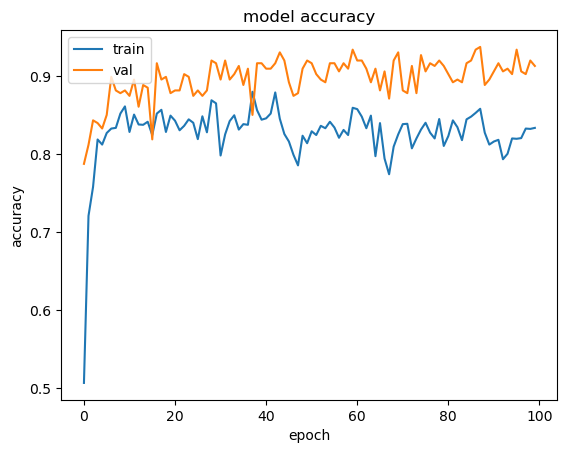

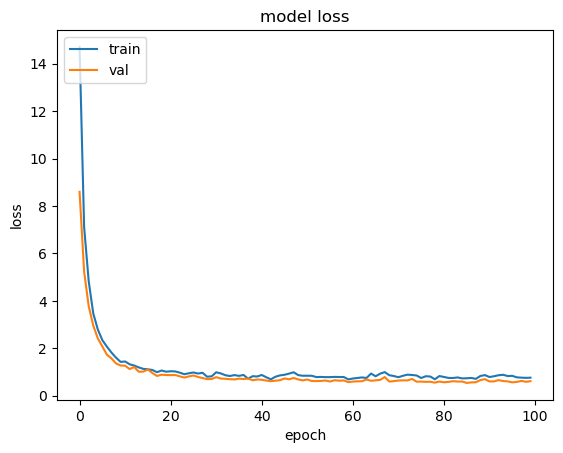

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_dir="/kaggle/working/test"
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 290 images belonging to 7 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


10/10 [==============================] - 2s 155ms/step - loss: 0.5549 - accuracy: 0.9276
Test loss: 0.5549452304840088
Test accuracy: 0.9275861978530884


In [ ]:
model.save("car_classifier_resnet.h5")